In [1]:
%env CUDA_VISIBLE_DEVICES=0
%load_ext autoreload
%autoreload 2
%matplotlib inline

from pathlib import Path

import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

from imgaug import augmenters as iaa
from sklearn.model_selection import train_test_split

import sys
sys.path.append("../")
import maskflow

root_dir = Path("/home/hadim/.data/Neural_Network/Maskflow/Microtubule")
data_dir = root_dir / "Data"
model_dir = root_dir / "Logs"
saved_model_dir = root_dir / "SavedModel"
log_file = model_dir / "current_training.log"

# Import the configuration associated with this dataset and network.
params = maskflow.load_parameters(root_dir / "parameters.yml")

env: CUDA_VISIBLE_DEVICES=0


Using TensorFlow backend.


# Load Dataset

In [2]:
# Split dataset
fnames = list((data_dir / "Image").glob("*.tif"))
#fnames = np.random.choice(fnames, 50)
train_fnames, validation_fnames = train_test_split(fnames, test_size=0.15, random_state=10)

# Build dataset
dataset_train = maskflow.MaskflowDataset()
dataset_train.set_dataset(train_fnames, params["CLASS_NAMES"])

dataset_val = maskflow.MaskflowDataset()
dataset_val.set_dataset(validation_fnames, params["CLASS_NAMES"])

print(f"train_fnames : {len(train_fnames)} | validation_fnames : {len(validation_fnames)}")

train_fnames : 78 | validation_fnames : 14


{'id': 0, 'source': '', 'path': PosixPath('/home/hadim/.data/Neural_Network/Maskflow/Microtubule/Data/Image/image_snr_1.3_n-mts_50.0_id_1.tif'), 'mask_path': PosixPath('/home/hadim/.data/Neural_Network/Maskflow/Microtubule/Data/Mask/image_snr_1.3_n-mts_50.0_id_1.tif'), 'class_ids_path': PosixPath('/home/hadim/.data/Neural_Network/Maskflow/Microtubule/Data/Class/image_snr_1.3_n-mts_50.0_id_1.csv')}


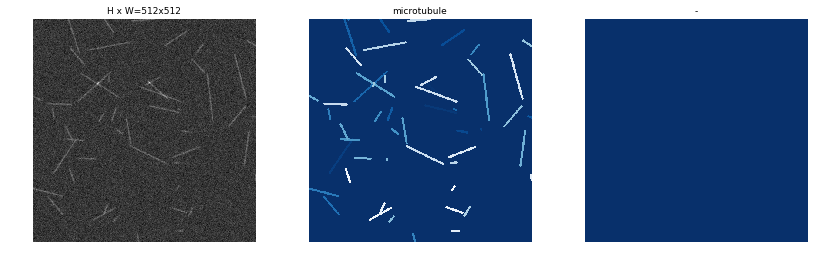

{'id': 23, 'source': '', 'path': PosixPath('/home/hadim/.data/Neural_Network/Maskflow/Microtubule/Data/Image/field_14.tif'), 'mask_path': PosixPath('/home/hadim/.data/Neural_Network/Maskflow/Microtubule/Data/Mask/field_14.tif'), 'class_ids_path': PosixPath('/home/hadim/.data/Neural_Network/Maskflow/Microtubule/Data/Class/field_14.csv')}


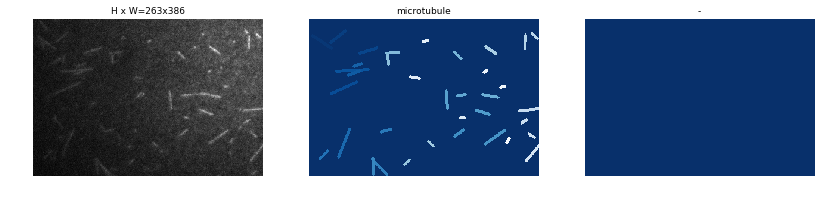

In [3]:
dataset_train.random_display(n=2, n_class=2)

# Training

In [4]:
# Configure the model and the training
config = maskflow.get_config(params)

config.IMAGES_PER_GPU = 4
config.GPU_COUNT = 2
config.update()

config.STEPS_PER_EPOCH = dataset_train.num_images // config.BATCH_SIZE
config.VALIDATION_STEPS = dataset_val.num_images // config.BATCH_SIZE
config.LEARNING_RATE = 0.0001

config.update()
#config.display()

In [ ]:
# Set the training name to resume a training or to None to start training from scratch.
training_name = "run_2"
#training_name = None

# When training from scratch you can init the network with "coco" or "imagenet"
init_with = "coco"

# Load model
model = maskflow.load_model(model_dir, config, training_name=training_name,
                            mode="training", init_with=init_with)
model.load_weights()

2018-07-11 03:39:34:Maskflow:INFO:Set log_dir to /home/hadim/.data/Neural_Network/Maskflow/Microtubule/Logs/run_2
2018-07-11 03:39:34:Maskflow:INFO:Found weights from epoch 51
2018-07-11 03:39:34:Maskflow:INFO:Start building Keras model.


In [ ]:
# Callback to execute during training
callbacks = []
callbacks.append(maskflow.FileLogger(log_file))
callbacks.append(maskflow.TelegramLogger())

In [ ]:
augmentation = iaa.SomeOf((0, 2), [
        iaa.Fliplr(0.5),
        iaa.Flipud(0.5),
        iaa.OneOf([iaa.Affine(rotate=90),
                   iaa.Affine(rotate=180),
                   iaa.Affine(rotate=270)]),
        iaa.Multiply((0.8, 1.5)),
        iaa.GaussianBlur(sigma=(0.0, 2.0))])

In [ ]:
model.train(dataset_train, dataset_val, epochs=500, layers='all',
            custom_callbacks=callbacks,
            learning_rate=config.LEARNING_RATE,
            augmentation=augmentation)

# Detection

In [4]:
training_name = "run_2"

config = maskflow.get_config(params)
config.IMAGES_PER_GPU = 1
config.GPU_COUNT = 1
config.update()

model = maskflow.load_model(model_dir, config, training_name=training_name, mode="inference")
model.load_weights()

2018-07-11 10:34:56:Maskflow:INFO:Set log_dir to /home/hadim/.data/Neural_Network/Maskflow/Microtubule/Logs/run_2
2018-07-11 10:34:56:Maskflow:INFO:Found weights from epoch 122
2018-07-11 10:34:56:Maskflow:INFO:Start building Keras model.
2018-07-11 10:35:00:Maskflow:INFO:Keras model built.
2018-07-11 10:35:00:Maskflow:INFO:Load weights from previous training /home/hadim/.data/Neural_Network/Maskflow/Microtubule/Logs/run_2/mask_rcnn_microtubule_detector_0122.h5.
2018-07-11 10:35:06:Maskflow:INFO:Done loading weights.


## Load one image

{'id': 11, 'source': '', 'path': PosixPath('/home/hadim/.data/Neural_Network/Maskflow/Microtubule/Data/Image/image_snr_3.1_n-mts_50.0_id_0.tif'), 'mask_path': PosixPath('/home/hadim/.data/Neural_Network/Maskflow/Microtubule/Data/Mask/image_snr_3.1_n-mts_50.0_id_0.tif'), 'class_ids_path': PosixPath('/home/hadim/.data/Neural_Network/Maskflow/Microtubule/Data/Class/image_snr_3.1_n-mts_50.0_id_0.csv')}


100%|██████████| 1/1 [00:00<00:00,  1.50it/s]


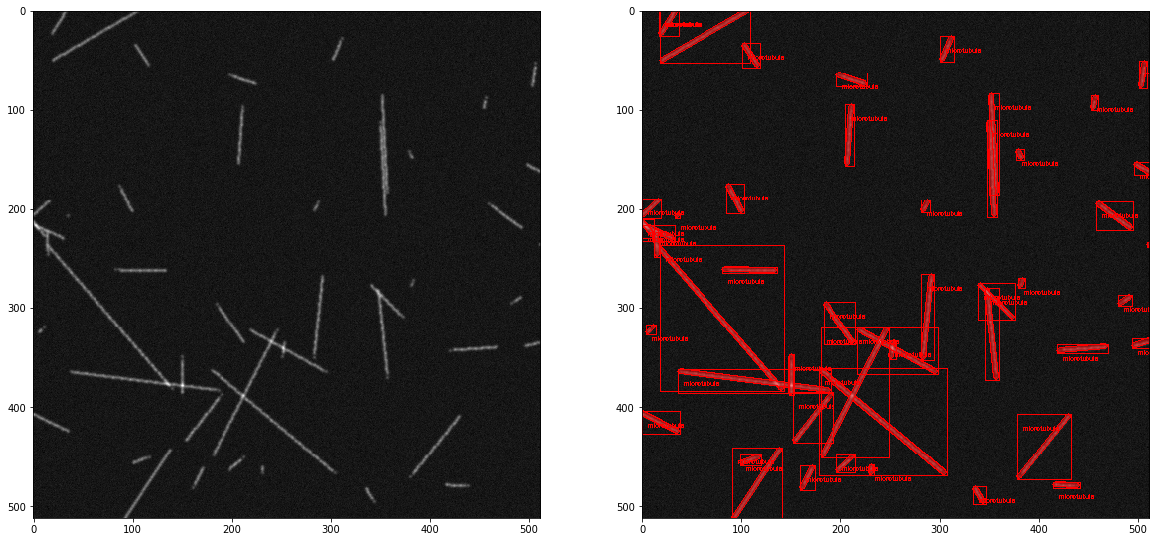

In [34]:
# Load a random image
image_id = np.random.choice(dataset_val.image_ids)
#image_id = 5

print(dataset_val.image_info[image_id])
image, objects = dataset_val.load(image_id)

image_objects = maskflow.draw_objects(image, objects, config.CLASS_NAMES, colors=None, resize_ratio=1,
                                      draw_boxes=True, draw_masks=True, draw_contours=True, draw_score=True)
maskflow.show_images([image, image_objects], size=10, use_widget=False, t=0)

## Detect objects

In [35]:
results = model.predict(image, progress=True)

images_results = maskflow.draw_objects(image, results, config.CLASS_NAMES, colors=None, resize_ratio=1,
                                       draw_boxes=True, draw_masks=True, draw_contours=True, draw_score=True)
maskflow.show_images([image_objects, images_results], size=10, use_widget=False, t=0)

  0%|          | 0/1 [00:00<?, ?it/s]


ValueError: low >= high

# Export trained model to ZIP

In [17]:
maskflow.export_to_zip(model, training_name, saved_model_dir)

INFO:tensorflow:Froze 384 variables.


INFO:tensorflow:Froze 384 variables.


Converted 384 variables to const ops.
